# Train Classifier

This script creates features and trains classifier

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import LinearSVC
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import configparser as cp
import cv2
import numpy as np
from pickle import dump
from pickle import load
import glob
import time

%matplotlib inline


In [2]:
# Get feature and model File names from saved config file
file_config = cp.ConfigParser()
configs = file_config.read('Project 5 - file_locations.ini')
svc_filename = file_config.get('file_locations', 'svc_filename')
car_features_filename = file_config.get('file_locations', 'car_features_filename')
no_car_features_filename = file_config.get('file_locations', 'no_car_features_filename')

## Functions

### Misc. Functions

In [3]:
# Function to get training images
def get_train_data():
    images = glob.glob('data/*/*/*.png', recursive=True)
    cars = []
    notcars = []
    for image in images:
        if 'non-vehicles' in image:
            notcars.append(image)
        else:
            cars.append(image)

    return cars, notcars


def display_images(img, cmap=None):
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 1, 1)    
#     plt.axis('off')
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    


### Feature Extractions Functions

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys', 
                                  transform_sqrt=transform_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2-Hys',
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# def color_hist(img, nbins=32, bins_range=(0, 256)):
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    transform_sqrt=True  # we will set this false if color space = LUV or YUV
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Hog function can cause error in YUV or LUV color spaces
            if color_space == 'LUV' or color_space == 'YUV' :
                transform_sqrt=False
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':                
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, transform_sqrt=transform_sqrt))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True, transform_sqrt=transform_sqrt)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Feature Prediction Functions

In [5]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_img(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

## Extract Features

In [6]:
# Parameters for feature extraction
color_space = 'YCrCb'
pix_per_cell = 16
cell_per_block = 2 # HOG cells per block
orient = 9
hog_channel = 'ALL'
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [7]:
cars, notcars = get_train_data()
t=time.time()
print('Extracting features...')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...\n')

Extracting features...
48.53 Seconds to extract features...



In [8]:
# Save car and notcar features for future use
dump(car_features, open(car_features_filename, 'wb'))
dump(notcar_features, open(no_car_features_filename, 'wb'))

# Train Classifier

In [9]:
# # Load features if necessary
# car_features = load(open(car_features_filename, 'rb'))
# notcar_features = load(open(no_car_features_filename, 'rb'))

In [10]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split into train & test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [11]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Save model
dump(svc, open(svc_filename, 'wb'))

4.02 Seconds to train SVC...
Test Accuracy of SVC =  0.989


In [12]:
# Check the prediction time for sample images
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
0.003 Seconds to predict 10 labels with SVC


# Test Classifier on Single Image

In [13]:
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
scale = 1.5

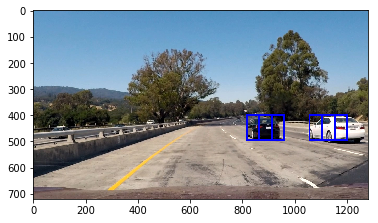

In [14]:
img = 'test_images/test1.jpg'
image = mpimg.imread(img)
out_img = find_cars_img(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

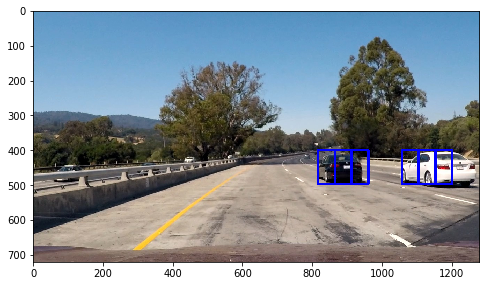

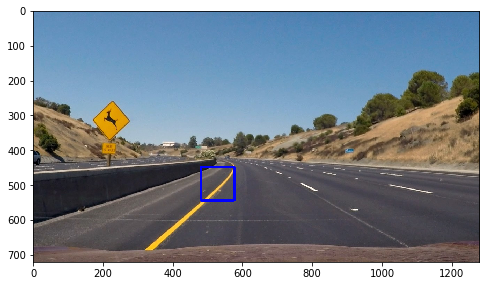

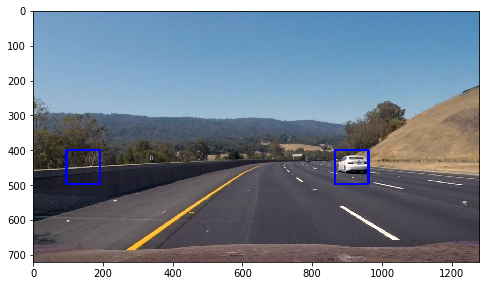

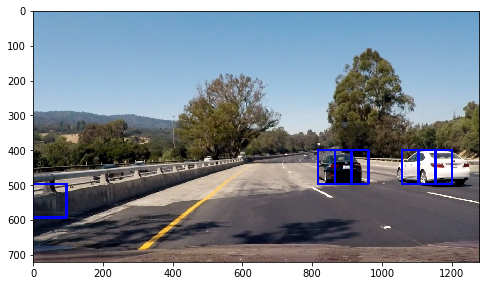

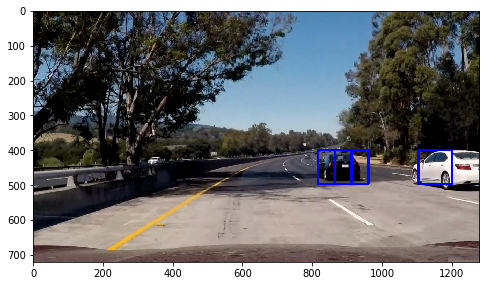

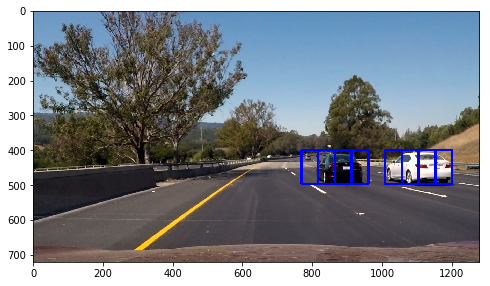

In [15]:
test_images = glob.glob('test_images/*.jpg')
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
scale = 1.5

for img in test_images:
    image = mpimg.imread(img)        
    out_img = find_cars_img(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
               
    display_images(out_img)